In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

2024-09-19 00:05:44.455308: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 00:05:44.557078: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 00:05:44.605203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 00:05:44.699841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 00:05:44.715006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 00:05:44.820641: I tensorflow/core/platform/cpu_feature_gu

# **Построение и обучение модели для выполнения функции логического "Исключающего ИЛИ" (XOR)** 

In [2]:
X = tf.constant([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=tf.float32) # входные данные x1 и x2 (признаки, характеризующие объект)
Y = tf.constant([[0], [1], [1], [0]], dtype=tf.float32) # желаемый выход (метки классов для каждого объекта)

In [3]:
# Вспомогательная функция для отрисовки границы решения
def plot_decision_boundary(model, X, y):

  # Определются границы рассматриваемого пространства (минимальный и максимальный x и y) и создаётся его сетка meshgrid
  X = X.numpy()
  y = y.numpy()
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx1, xx2 = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

  # Создаются входные сигналы X (мы собираемся предсказывать значения по всей сетке рассматриваемого пространства)
  x_in = np.c_[xx1.ravel(), xx2.ravel()] # соединяем 2D массивы вместе: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Осуществляется предсказание для входных сигналов X
  y_pred = model.predict(x_in, batch_size=1024)
  y_pred = np.round(np.max(y_pred, axis=-1)).reshape(xx1.shape) # reshape необходим поскольку результатом будет 1D вектор, а необходим 2D, как у xx1

  # Визуализация границ решения
  plt.contourf(xx1, xx2, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.pause(0.01)

# Вспомогательный колбэк для отрисовки границы решений каждые 100 эпох и остановки обучения если точность достигла 1.0
class PlotAndStopCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:  # Отрисовываем каждые 100 эпох
            print(f"Epoch {epoch + 1}")
            plot_decision_boundary(self.model, X, Y)

        if logs.get('accuracy') == 1.0:  # Остановка, если точность достигла 1.0
            print(f"\nStopping training at epoch {epoch + 1} as accuracy reached 1.0")
            plot_decision_boundary(self.model, X, Y)
            self.model.stop_training = True

In [4]:
###### Основной код ######

def createModel(input_shape):
  input_x = Input(shape=(input_shape, )) # для создания модели необходимо предопределить вход и размерность входных данных input_shape
  z = Dense(1)(input_x) # создаём 1 нейрон и передаём в него входные сигналы input_x
  p = Activation('sigmoid')(z) # результат обработки нейроном входных сигналов z поступает в сигмоидальную функцию активации, которая выдаёт вероятность принадлежности к классу 1
  return Model(inputs=input_x, outputs=p) # создаём модель, задавая вход и выход и возвращаем эту модель для последующих манипуляций

def trainModel(X, Y): 
  model = createModel(2) # создаётся модель принимающая на вход входные сигналы с размерностью 2
  #  Компилируется модель, задаётся оптимизатор sgd - стохастический градиентный спуск (алгоритм минимизирующий функцию ошибки), можно ещё попробовать: adam, rmsprop
  #                       задаётся функция ошибки loss бинарная кроссэнтропия для задачи бинарной классификации (0 или 1)
  #                       задаётся метрика Accuracy - точность. Формула: отношение правильных предсказаний на общее количество предсказаний
  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary() # вывод информации о созданной модели
  callback = PlotAndStopCallback() # используем колбэк для отрисовки
  model.fit(x=X, y=Y, epochs=10000, callbacks=[callback]) # вызывается метод обучения, принимающий на вход X, Y и количество эпох обучения
  return model # обученная модель возвращается для тестирования и других манипуляций

def testModel(X_test, model):
  result = model.predict(X_test) # вызывается метод предсказания для входных тестовых данных
  print(result)
  # Задаётся решающее правило.
  if(result >= 0.5): # если выходная вероятность предсказания больше или равно 0.5 то возвращаем класс 1
    return 1
  elif(result < 0.5): # если выходная вероятность предсказания меньше 0.5 то возвращаем класс 0
    return 0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7500 - loss: 0.8229
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.8221
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.8214
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.8207
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - loss: 0.8200
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.8192
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.8185
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.8178
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.8171
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.8164
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.8157
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/ste

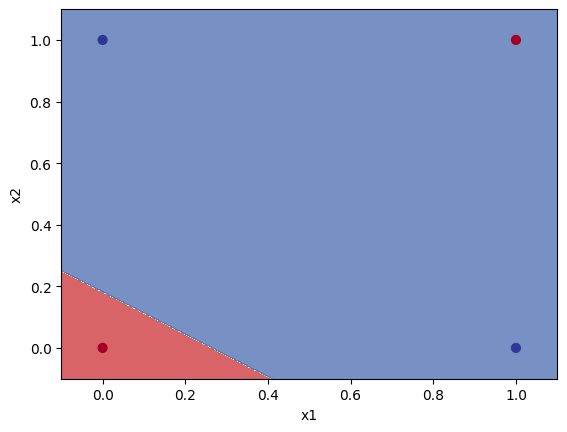

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - accuracy: 0.7500 - loss: 0.7672
Epoch 101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7668
Epoch 102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7664
Epoch 103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7660
Epoch 104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.7656
Epoch 105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7652
Epoch 106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7648
Epoch 107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7644
Epoch 108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.7640
Epoch 109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.7636
Epoch 110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.7632
Epoch 111/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

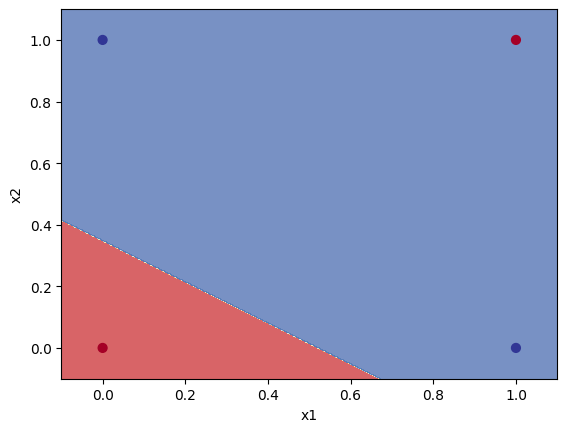

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7500 - loss: 0.7368
Epoch 201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7366
Epoch 202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7364
Epoch 203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7362
Epoch 204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7359
Epoch 205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.7357
Epoch 206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.7355
Epoch 207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7353
Epoch 208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.7351
Epoch 209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7349
Epoch 210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7347
Epoch 211/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20m

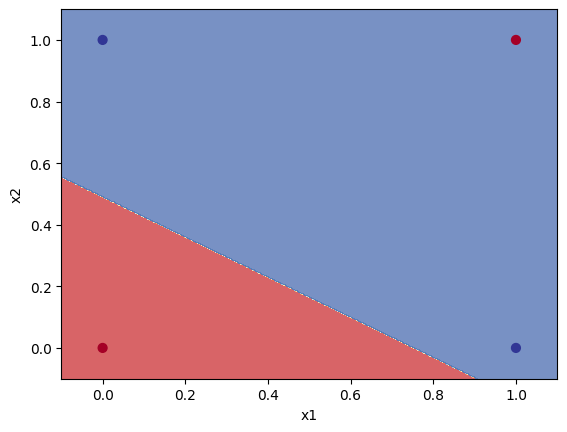

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7500 - loss: 0.7210
Epoch 301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.7209
Epoch 302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7208
Epoch 303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7207
Epoch 304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7206
Epoch 305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7205
Epoch 306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7204
Epoch 307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7203
Epoch 308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7202
Epoch 309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7201
Epoch 310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7200
Epoch 311/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

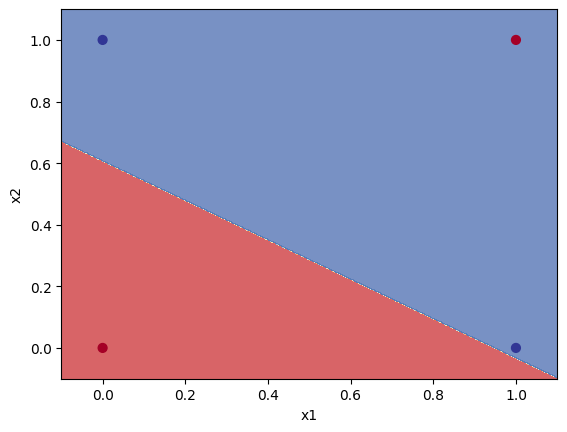

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7500 - loss: 0.7129
Epoch 401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7128
Epoch 402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.7128
Epoch 403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7127
Epoch 404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7127
Epoch 405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7126
Epoch 406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7126
Epoch 407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7125
Epoch 408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7124
Epoch 409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7124
Epoch 410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7123
Epoch 411/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

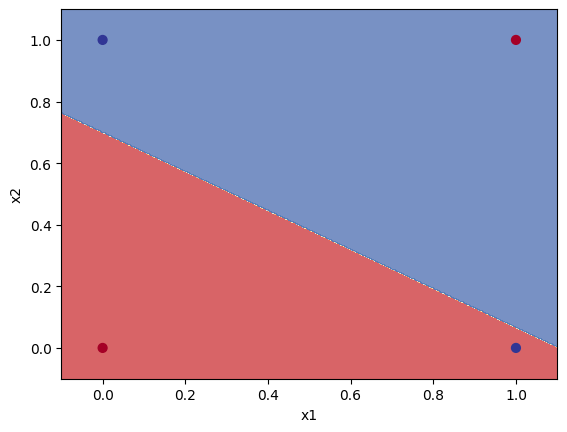

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5000 - loss: 0.7086
Epoch 501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 0.7085
Epoch 502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.7085
Epoch 503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7085
Epoch 504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 0.7084
Epoch 505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7084
Epoch 506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7084
Epoch 507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.7083
Epoch 508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7083
Epoch 509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7083
Epoch 510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7082
Epoch 511/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

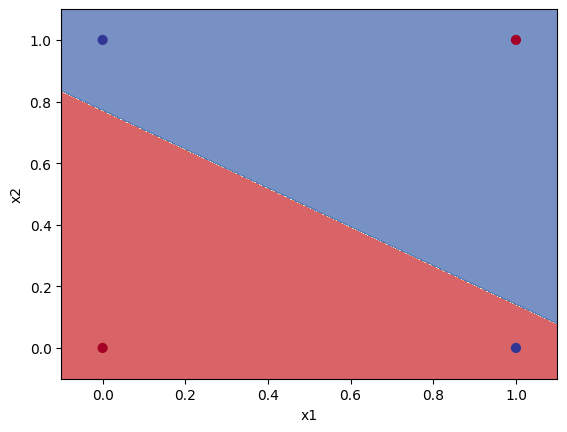

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5000 - loss: 0.7061
Epoch 601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7060
Epoch 602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 0.7060
Epoch 603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.7060
Epoch 604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.7060
Epoch 605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7060
Epoch 606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.7059
Epoch 607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7059
Epoch 608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7059
Epoch 609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7059
Epoch 610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7059
Epoch 611/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

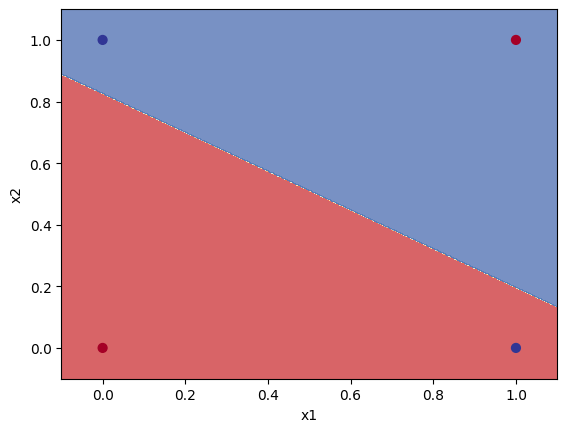

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5000 - loss: 0.7045
Epoch 701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7044
Epoch 709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7043
Epoch 710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7043
Epoch 711/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

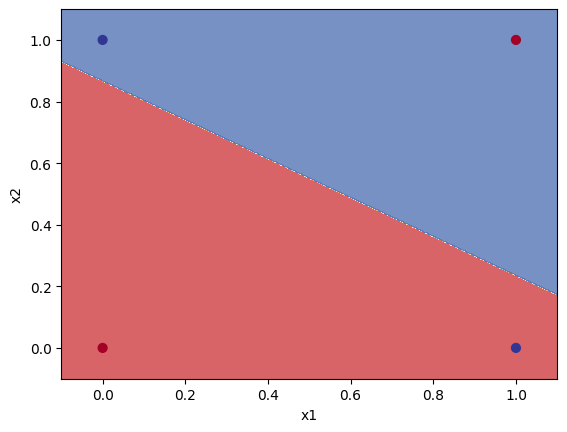

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5000 - loss: 0.7033
Epoch 801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.7033
Epoch 802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7033
Epoch 803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7033
Epoch 804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.7033
Epoch 805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7033
Epoch 806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7033
Epoch 807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7032
Epoch 808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.7032
Epoch 809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7032
Epoch 810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7032
Epoch 811/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

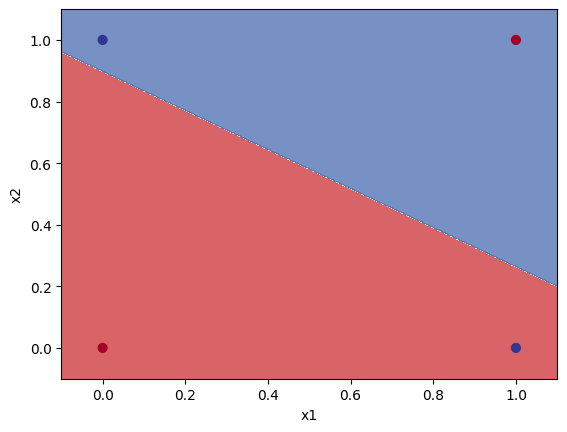

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.7024
Epoch 908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7023
Epoch 909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7023
Epoch 910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7023
Epoch 911/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

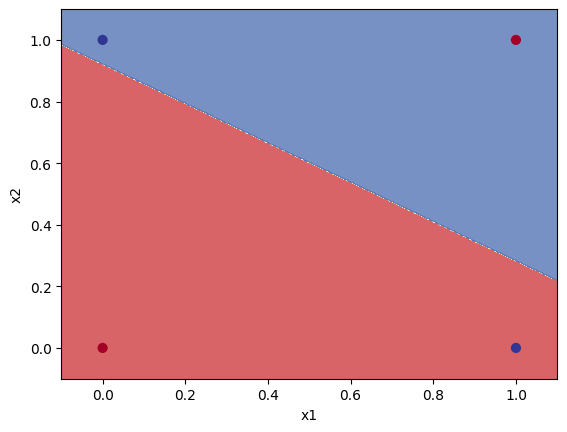

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.7016
Epoch 1011/10000
1/1 ━━━━━━━━━━━━━━━━

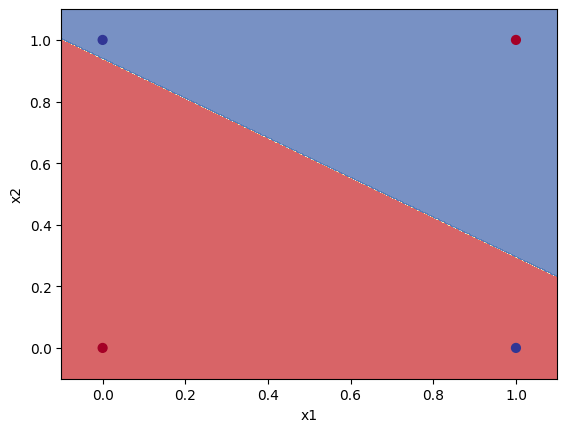

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5000 - loss: 0.7010
Epoch 1101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7010
Epoch 1102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.7010
Epoch 1103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.7010
Epoch 1104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7009
Epoch 1105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.7009
Epoch 1106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7009
Epoch 1107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 0.7009
Epoch 1108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.7009
Epoch 1109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7009
Epoch 1110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.7009
Epoch 1111/10000
1/1 ━━━━━━━━━━━━━━━━

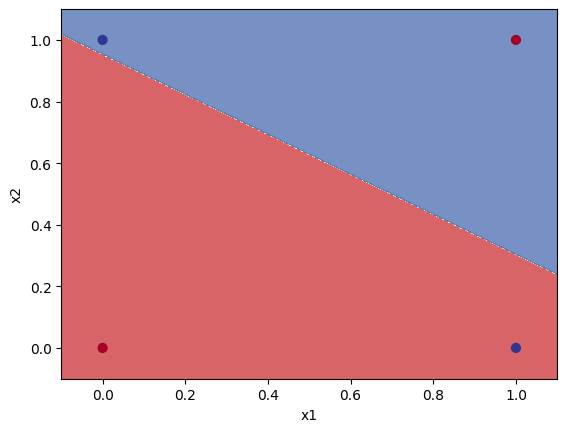

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5000 - loss: 0.7004
Epoch 1201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.7004
Epoch 1202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 0.7004
Epoch 1203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.7003
Epoch 1211/10000
1/1 ━━━━━━━━━━━━━━━━

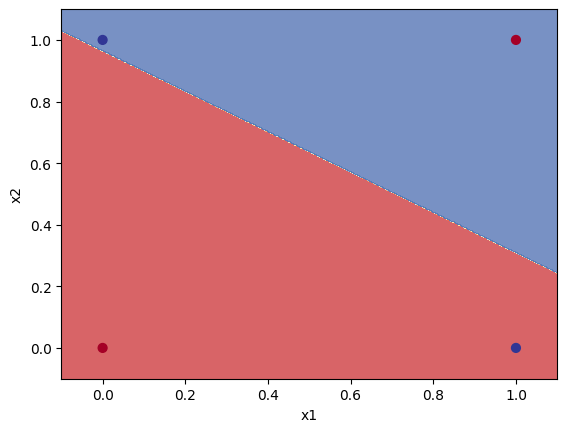

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6998
Epoch 1311/10000
1/1 ━━━━━━━━━━━━━━━━

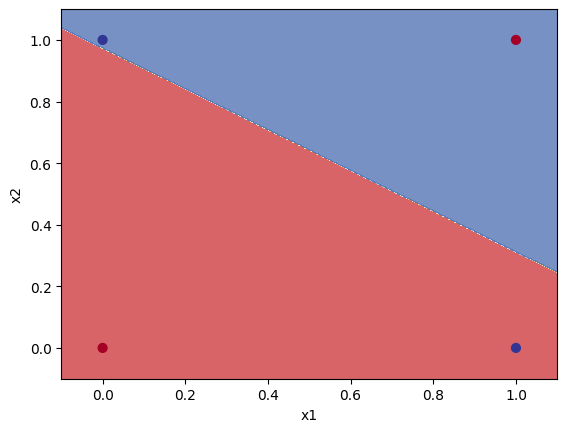

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6993
Epoch 1410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6992
Epoch 1411/10000
1/1 ━━━━━━━━━━━━━━━━

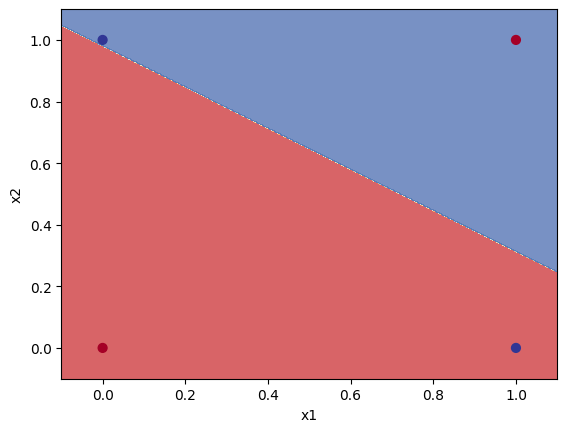

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6988
Epoch 1511/10000
1/1 ━━━━━━━━━━━━━━━━

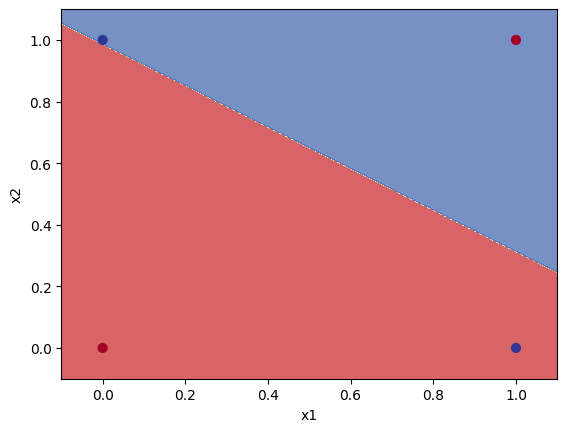

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6984
Epoch 1611/10000
1/1 ━━━━━━━━━━━━━━━━

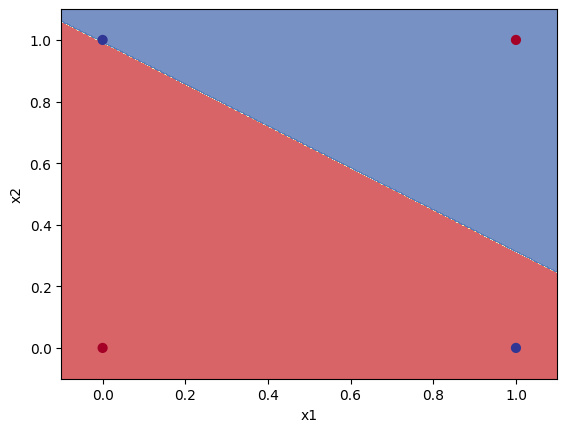

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.6980
Epoch 1711/10000
1/1 ━━━━━━━━━━━━━━━━

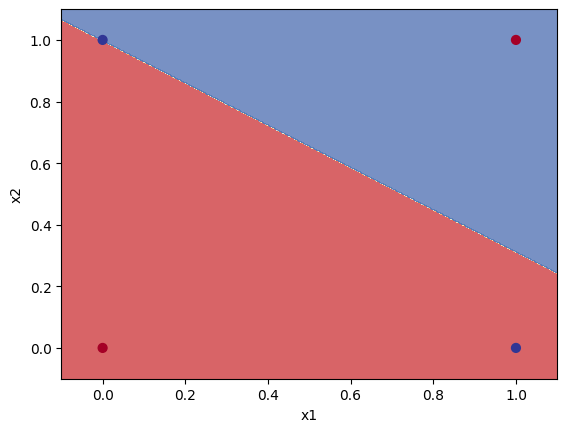

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 0.6976
Epoch 1811/10000
1/1 ━━━━━━━━━━━━━━━━

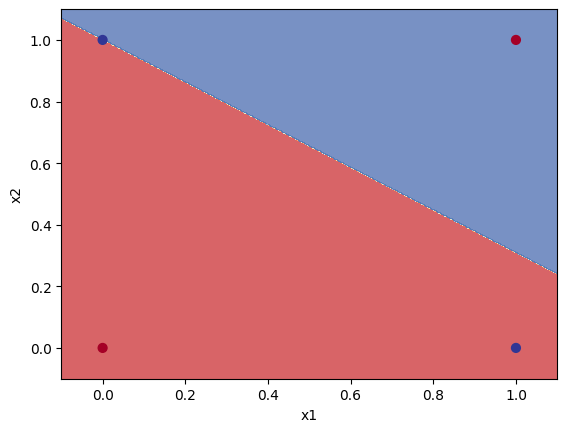

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6973
Epoch 1911/10000
1/1 ━━━━━━━━━━━━━━━━

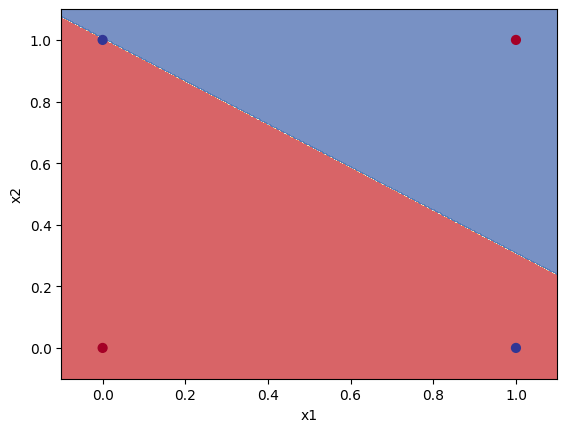

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.2500 - loss: 0.6970
Epoch 2001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6970
Epoch 2002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6970
Epoch 2003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6970
Epoch 2004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6970
Epoch 2005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6970
Epoch 2006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6970
Epoch 2007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6969
Epoch 2008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6969
Epoch 2009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6969
Epoch 2010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6969
Epoch 2011/10000
1/1 ━━━━━━━━━━━━━━━━

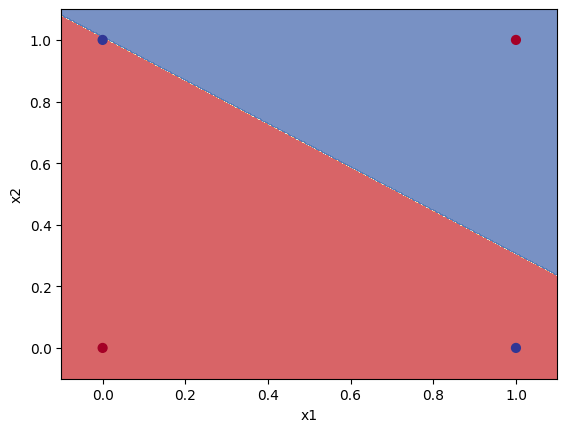

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6967
Epoch 2110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6966
Epoch 2111/10000
1/1 ━━━━━━━━━━━━━━━━

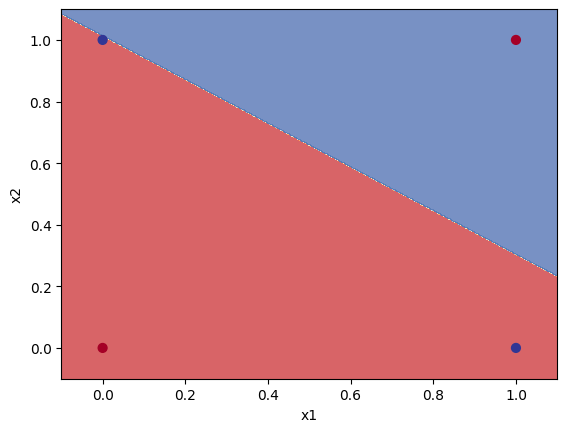

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6964
Epoch 2211/10000
1/1 ━━━━━━━━━━━━━━━━

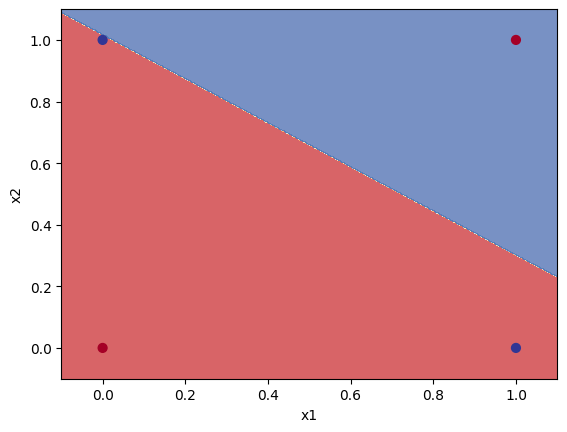

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.2500 - loss: 0.6962
Epoch 2301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6962
Epoch 2302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6962
Epoch 2303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6962
Epoch 2304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6962
Epoch 2305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6961
Epoch 2306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6961
Epoch 2307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6961
Epoch 2308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6961
Epoch 2309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6961
Epoch 2310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6961
Epoch 2311/10000
1/1 ━━━━━━━━━━━━━━━━

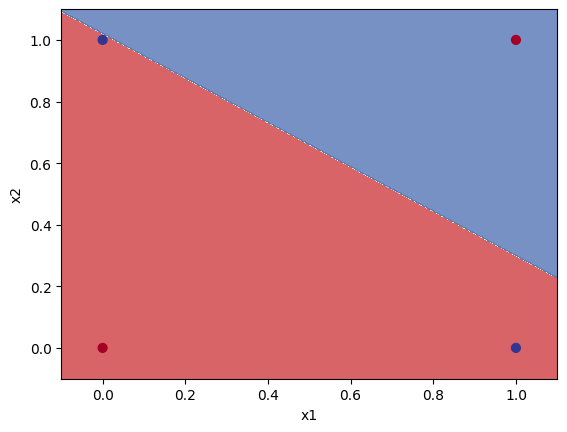

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6959
Epoch 2411/10000
1/1 ━━━━━━━━━━━━━━━━

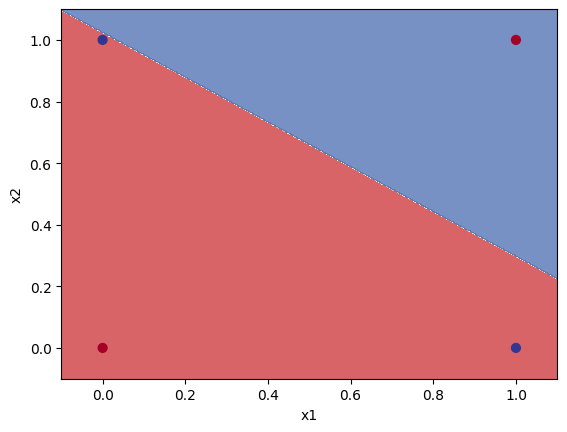

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6957
Epoch 2511/10000
1/1 ━━━━━━━━━━━━━━━━

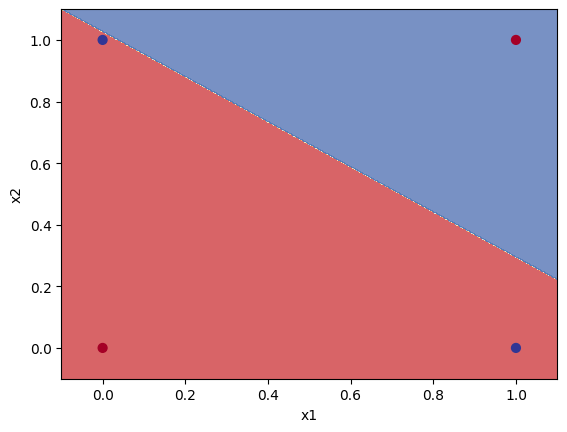

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6955
Epoch 2611/10000
1/1 ━━━━━━━━━━━━━━━━

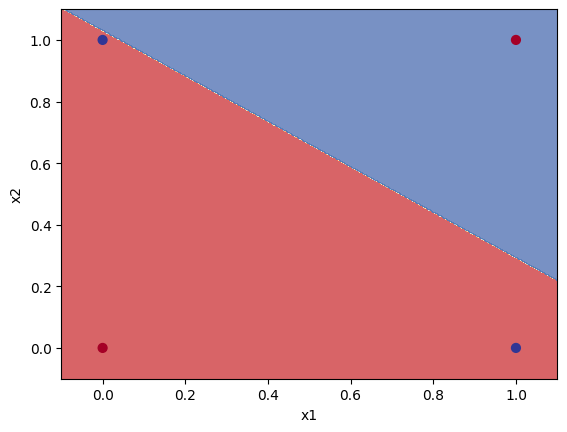

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6953
Epoch 2711/10000
1/1 ━━━━━━━━━━━━━━━━

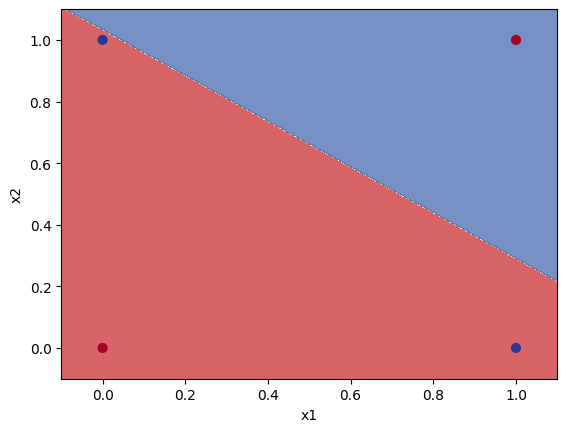

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6952
Epoch 2811/10000
1/1 ━━━━━━━━━━━━━━━━

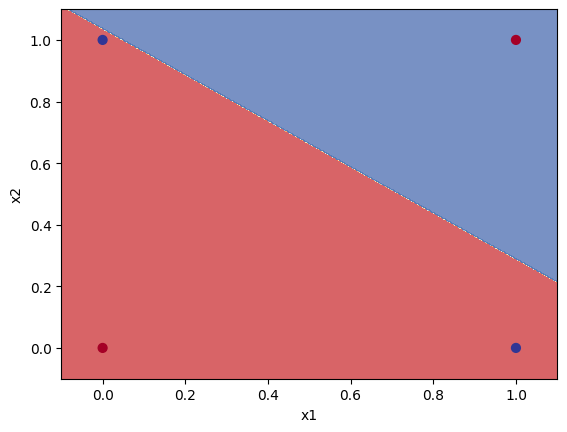

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6950
Epoch 2911/10000
1/1 ━━━━━━━━━━━━━━━━

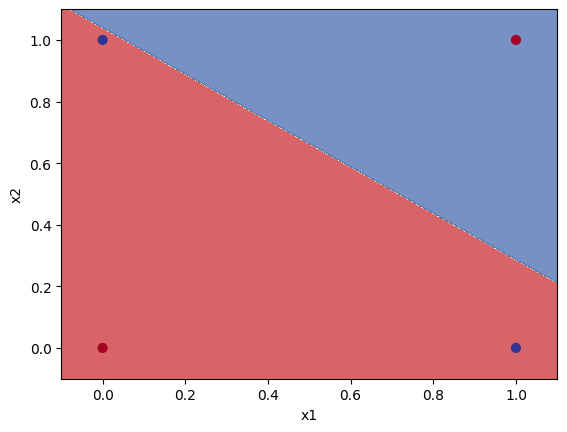

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6949
Epoch 3011/10000
1/1 ━━━━━━━━━━━━━━━━

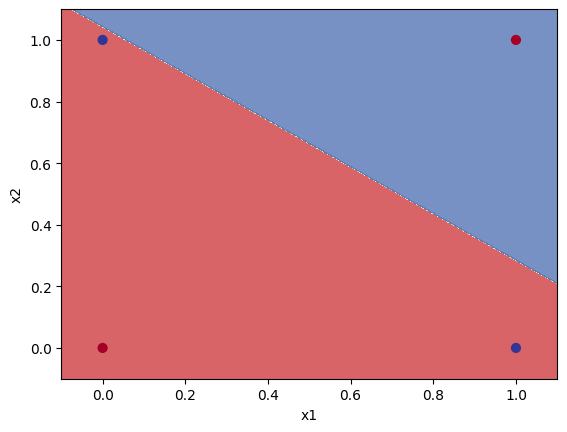

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6947
Epoch 3111/10000
1/1 ━━━━━━━━━━━━━━━━

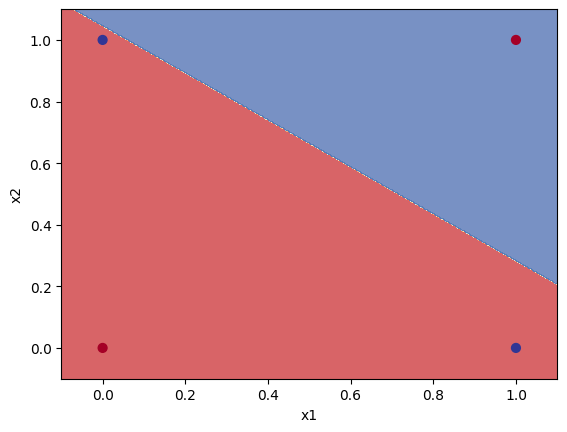

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6946
Epoch 3211/10000
1/1 ━━━━━━━━━━━━━━━━

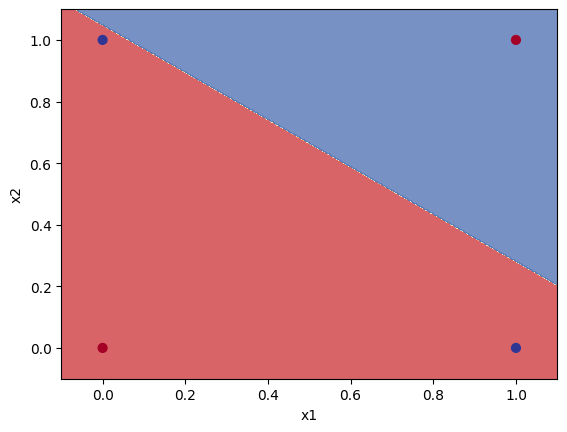

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6945
Epoch 3311/10000
1/1 ━━━━━━━━━━━━━━━━

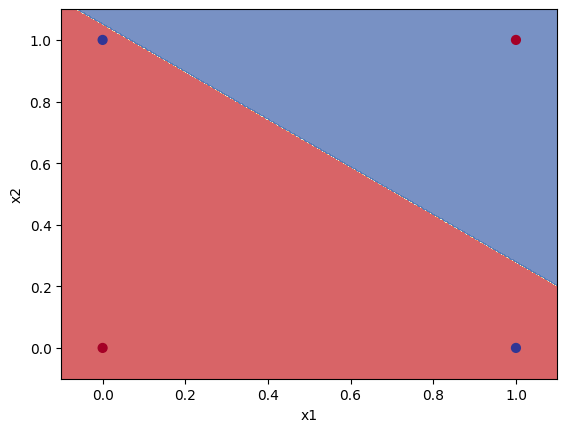

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6944
Epoch 3411/10000
1/1 ━━━━━━━━━━━━━━━━

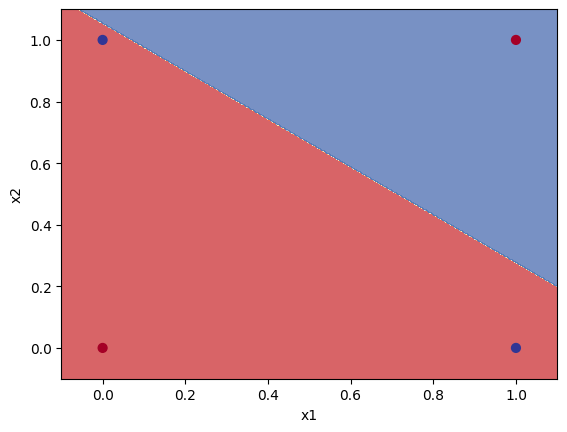

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6943
Epoch 3511/10000
1/1 ━━━━━━━━━━━━━━━━

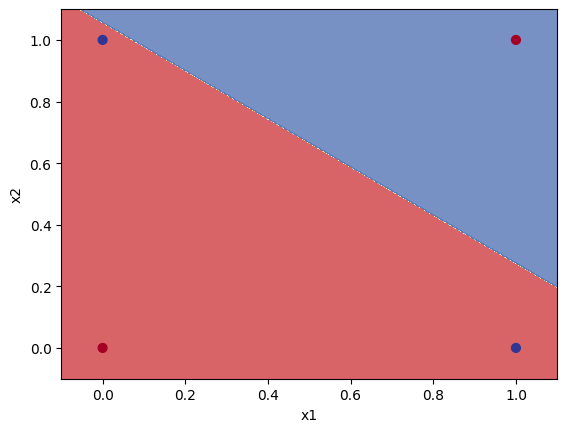

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6942
Epoch 3611/10000
1/1 ━━━━━━━━━━━━━━━━

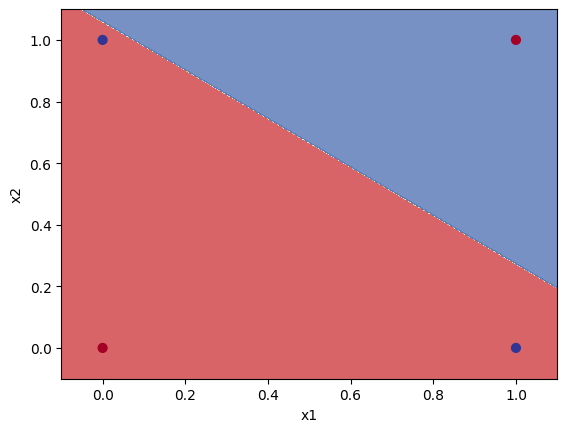

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3711/10000
1/1 ━━━━━━━━━━━━━━━━

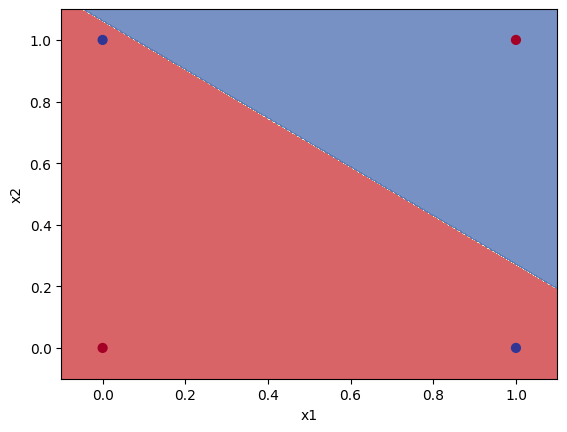

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6941
Epoch 3811/10000
1/1 ━━━━━━━━━━━━━━━━

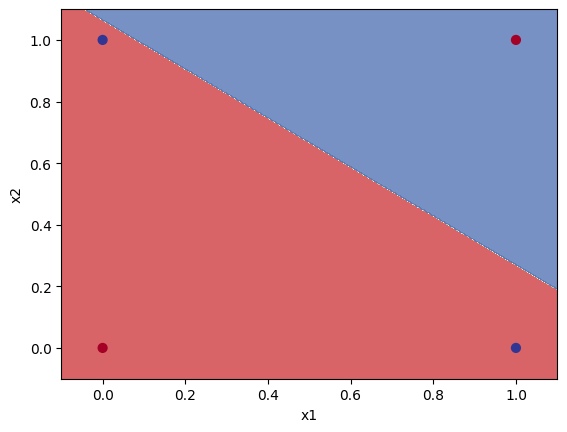

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6940
Epoch 3911/10000
1/1 ━━━━━━━━━━━━━━━━

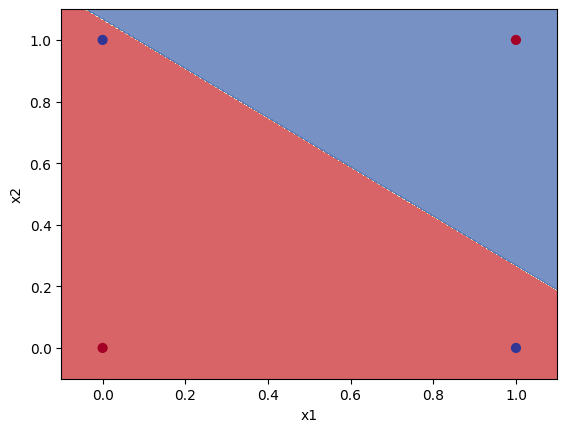

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4011/10000
1/1 ━━━━━━━━━━━━━━━━

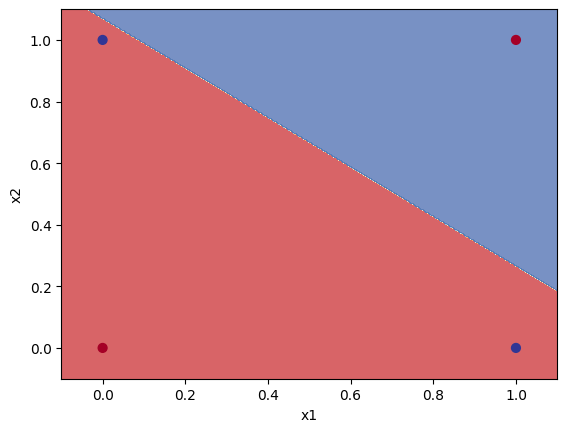

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6939
Epoch 4111/10000
1/1 ━━━━━━━━━━━━━━━━

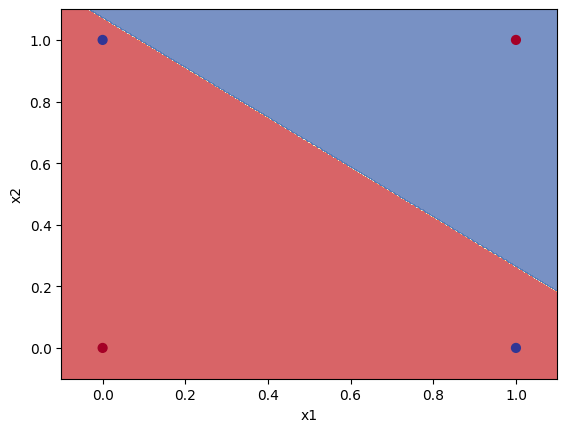

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4211/10000
1/1 ━━━━━━━━━━━━━━━━

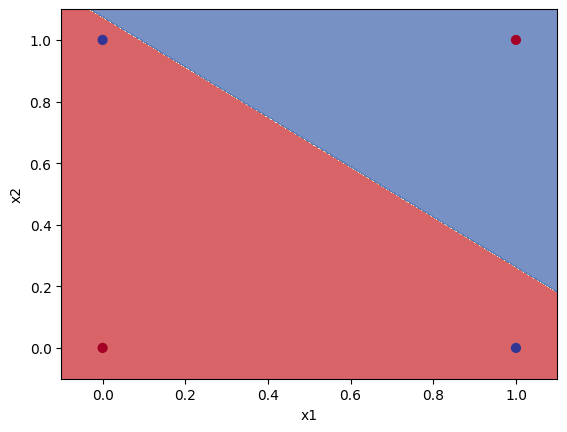

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6938
Epoch 4311/10000
1/1 ━━━━━━━━━━━━━━━━

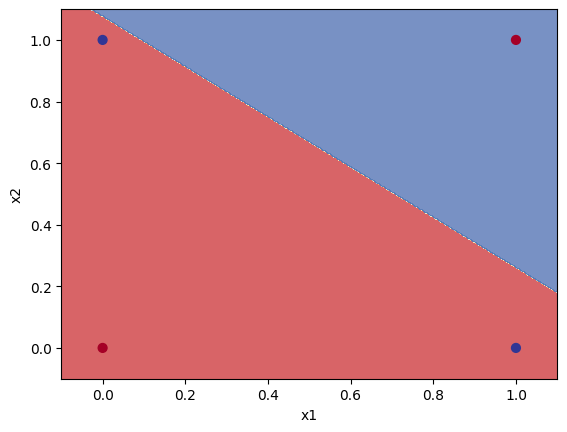

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4411/10000
1/1 ━━━━━━━━━━━━━━━━

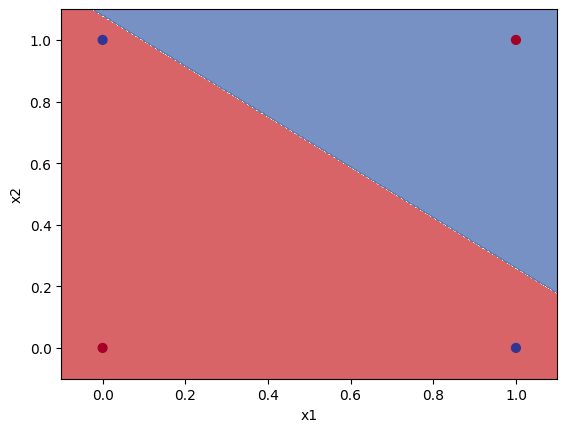

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6937
Epoch 4511/10000
1/1 ━━━━━━━━━━━━━━━━

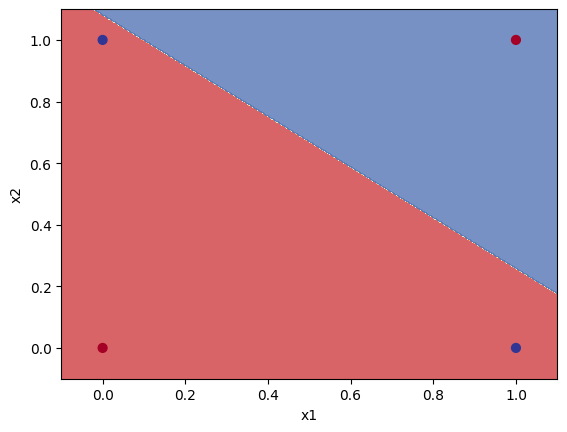

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4611/10000
1/1 ━━━━━━━━━━━━━━━━

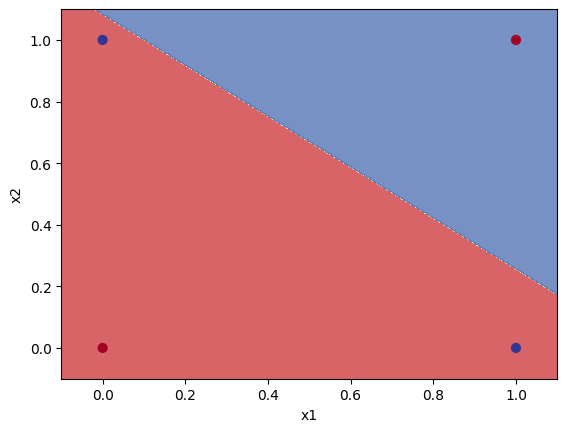

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4711/10000
1/1 ━━━━━━━━━━━━━━━━

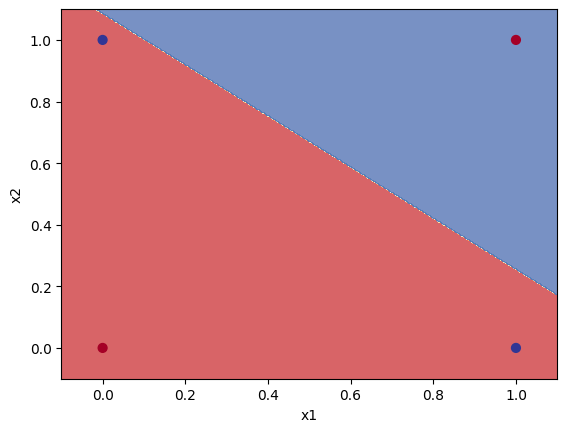

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6936
Epoch 4811/10000
1/1 ━━━━━━━━━━━━━━━━

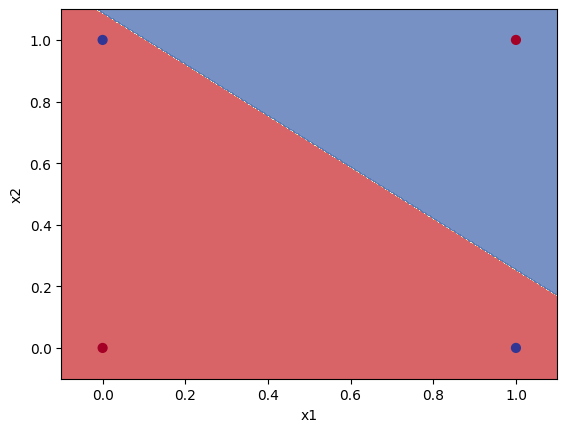

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 4911/10000
1/1 ━━━━━━━━━━━━━━━━

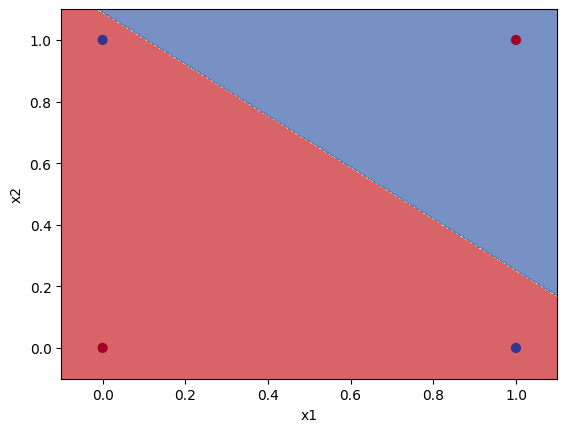

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5011/10000
1/1 ━━━━━━━━━━━━━━━━

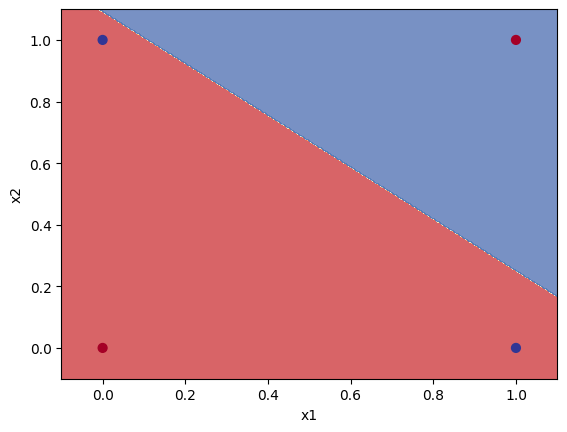

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5111/10000
1/1 ━━━━━━━━━━━━━━━━

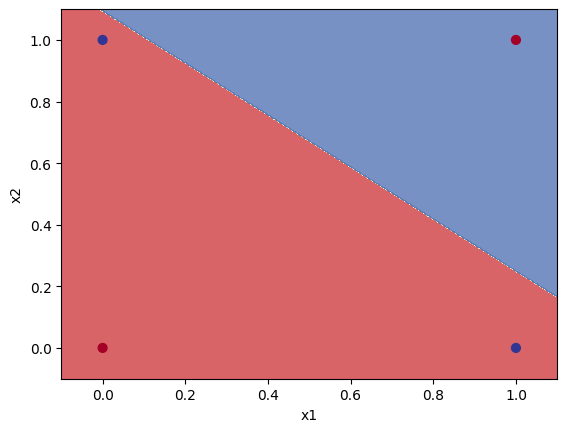

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2500 - loss: 0.6935
Epoch 5211/10000
1/1 ━━━━━━━━━━━━━━━━

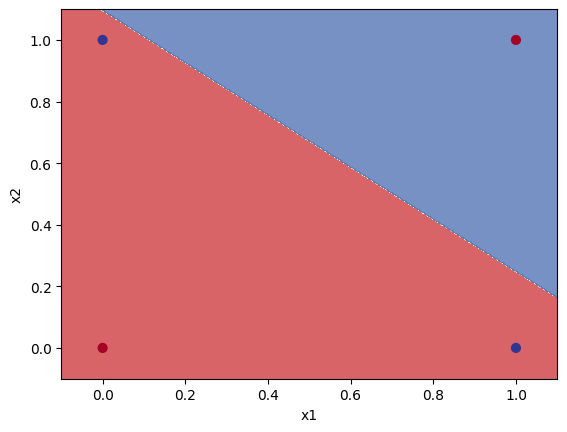

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5311/10000
1/1 ━━━━━━━━━━━━━━━━

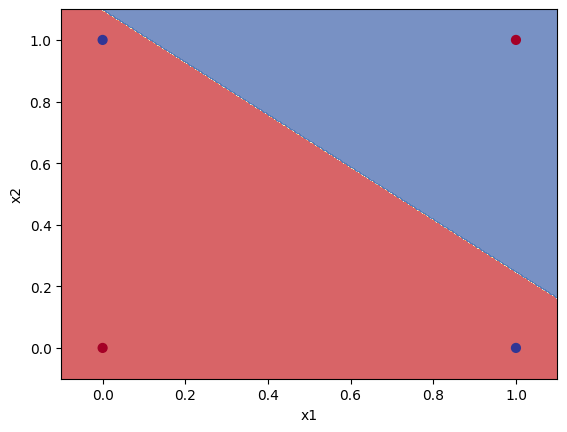

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5411/10000
1/1 ━━━━━━━━━━━━━━━━

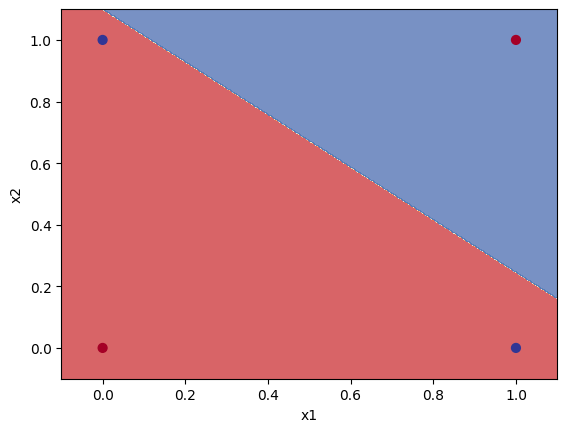

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5511/10000
1/1 ━━━━━━━━━━━━━━━━

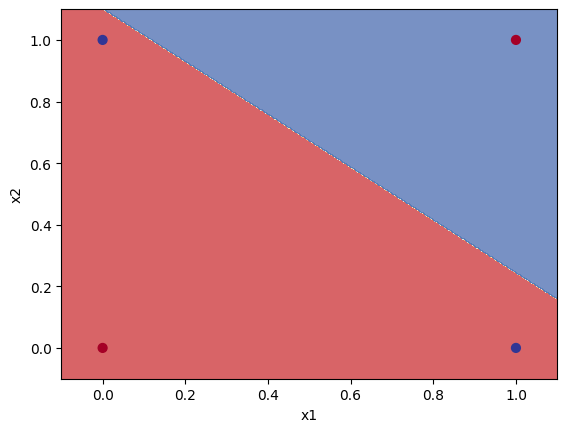

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5611/10000
1/1 ━━━━━━━━━━━━━━━━

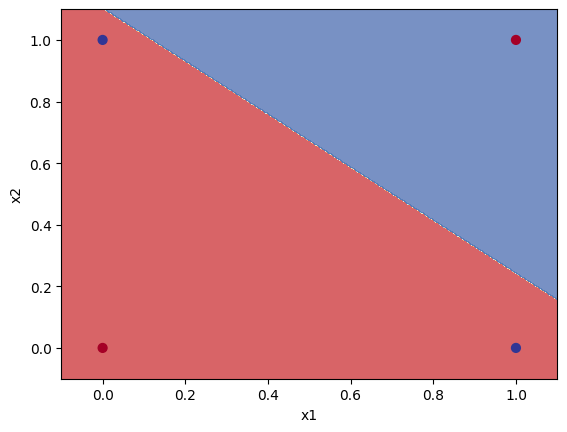

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6934
Epoch 5711/10000
1/1 ━━━━━━━━━━━━━━━━

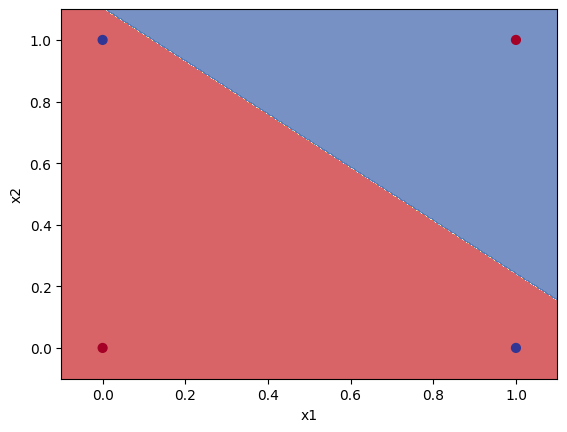

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5811/10000
1/1 ━━━━━━━━━━━━━━━━

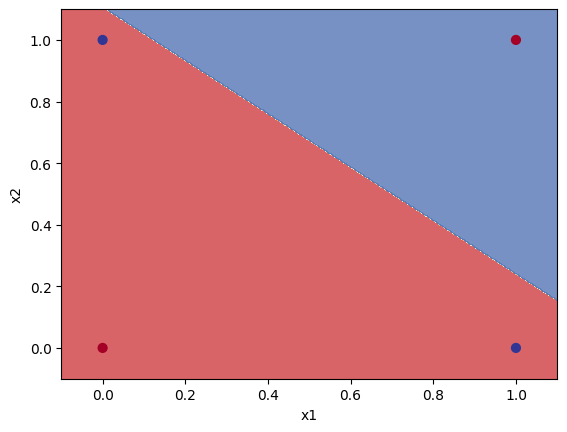

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 5911/10000
1/1 ━━━━━━━━━━━━━━━━

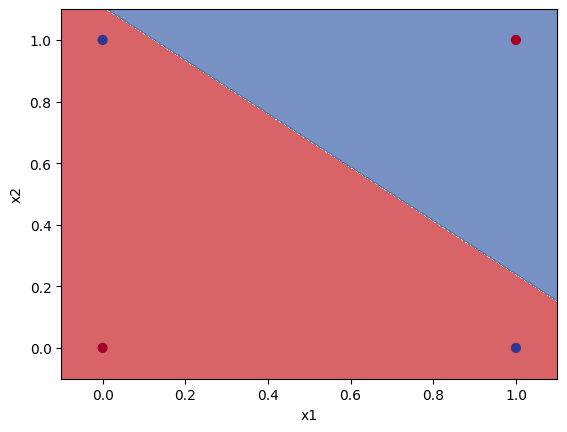

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6011/10000
1/1 ━━━━━━━━━━━━━━━━

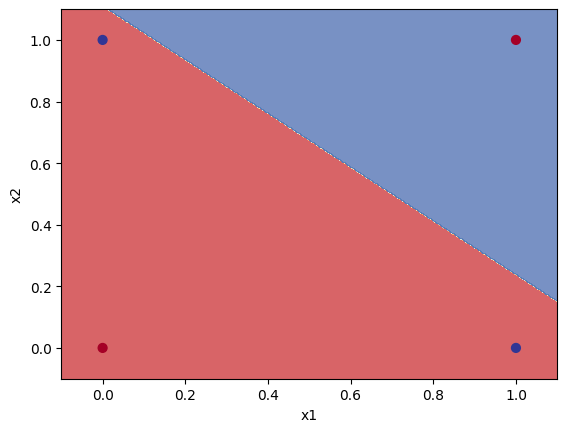

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6111/10000
1/1 ━━━━━━━━━━━━━━━━

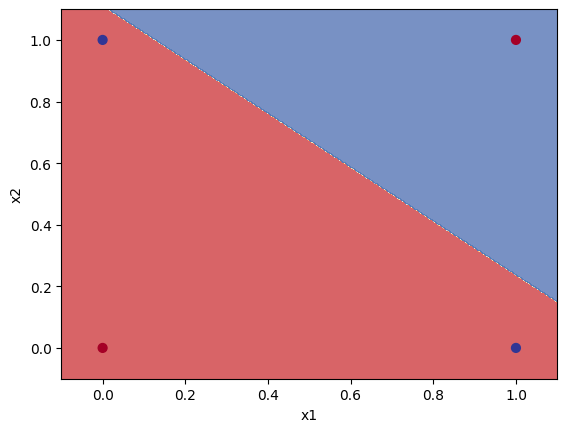

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6211/10000
1/1 ━━━━━━━━━━━━━━━━

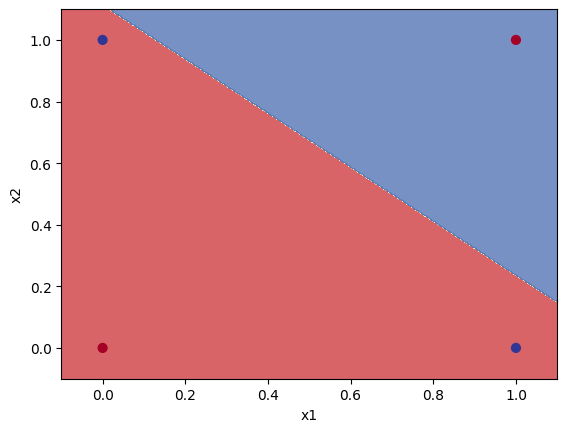

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6311/10000
1/1 ━━━━━━━━━━━━━━━━

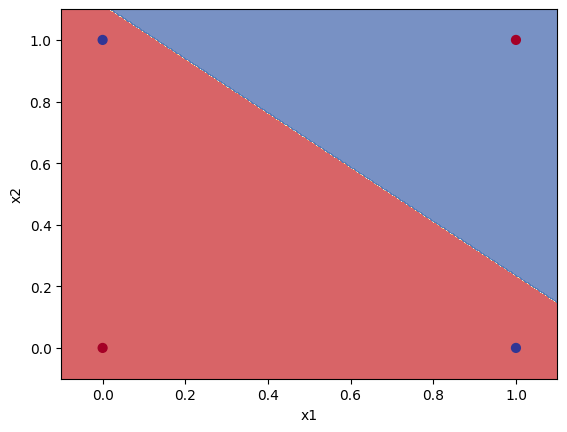

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6411/10000
1/1 ━━━━━━━━━━━━━━━━

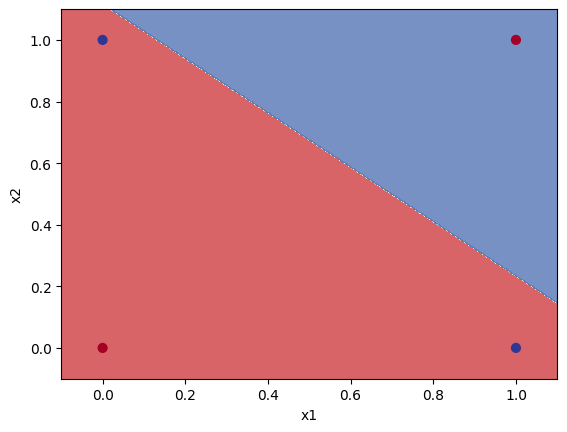

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6933
Epoch 6511/10000
1/1 ━━━━━━━━━━━━━━━━

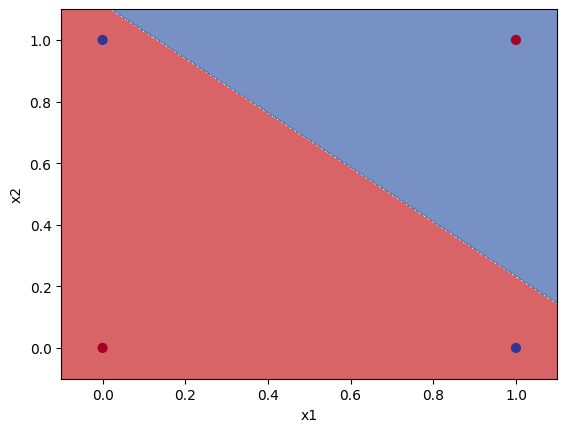

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6611/10000
1/1 ━━━━━━━━━━━━━━━━

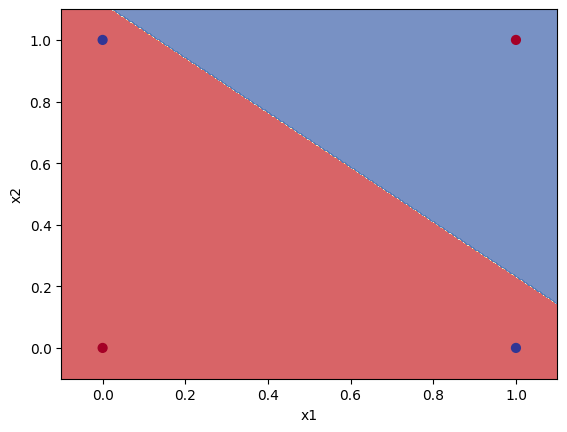

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6711/10000
1/1 ━━━━━━━━━━━━━━━━

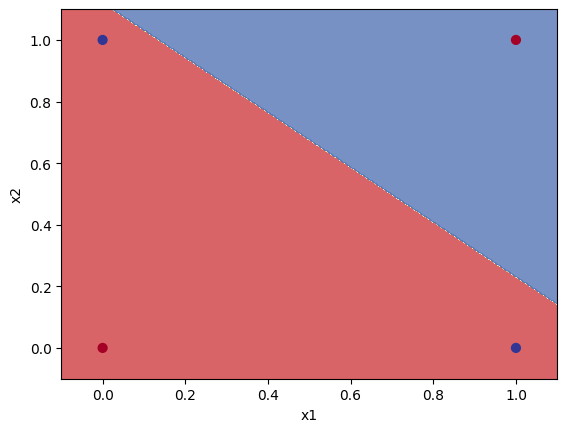

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6811/10000
1/1 ━━━━━━━━━━━━━━━━

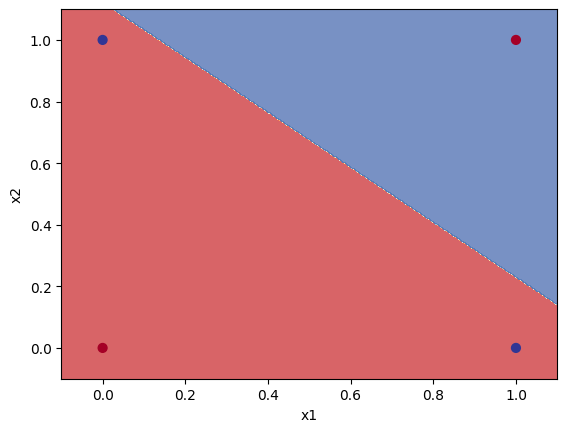

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 6911/10000
1/1 ━━━━━━━━━━━━━━━━

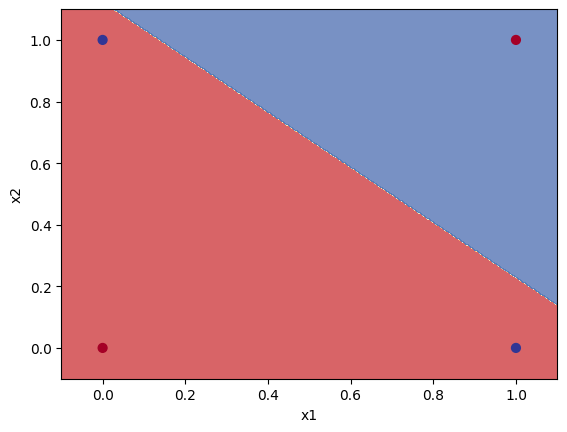

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7011/10000
1/1 ━━━━━━━━━━━━━━━━

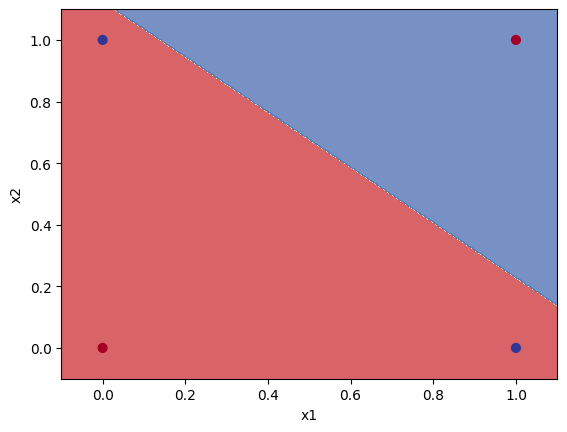

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7111/10000
1/1 ━━━━━━━━━━━━━━━━

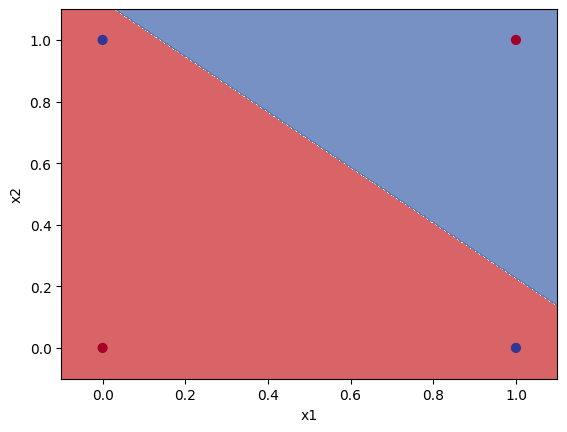

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7211/10000
1/1 ━━━━━━━━━━━━━━━━

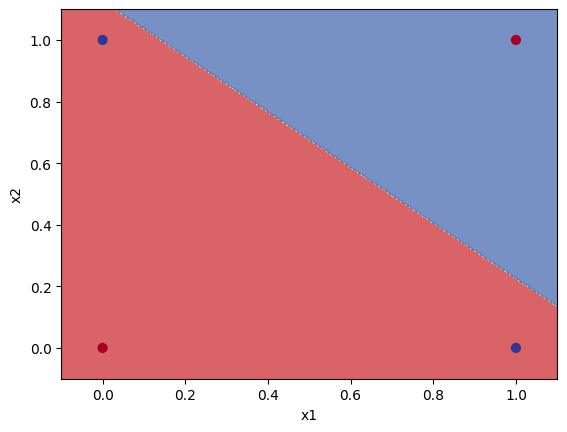

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7311/10000
1/1 ━━━━━━━━━━━━━━━━

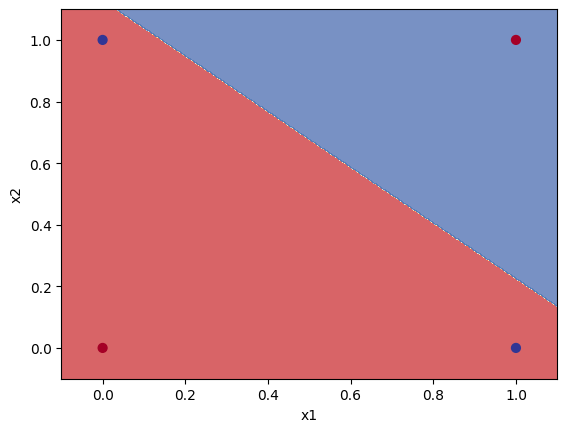

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7411/10000
1/1 ━━━━━━━━━━━━━━━━

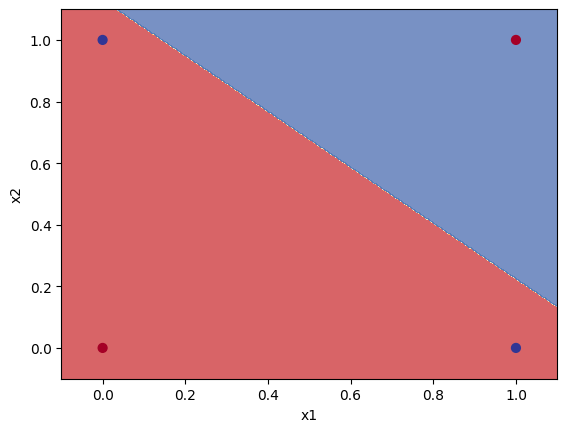

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7511/10000
1/1 ━━━━━━━━━━━━━━━━

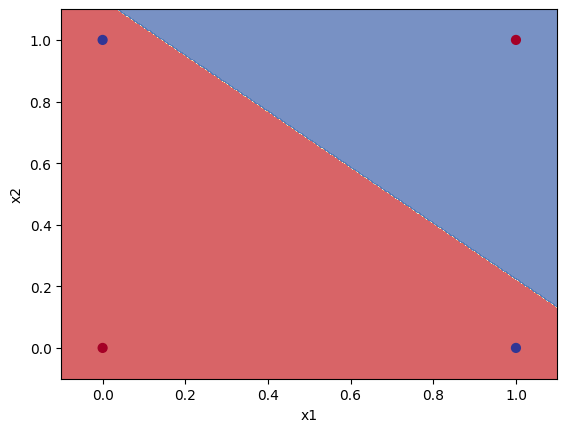

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7611/10000
1/1 ━━━━━━━━━━━━━━━━

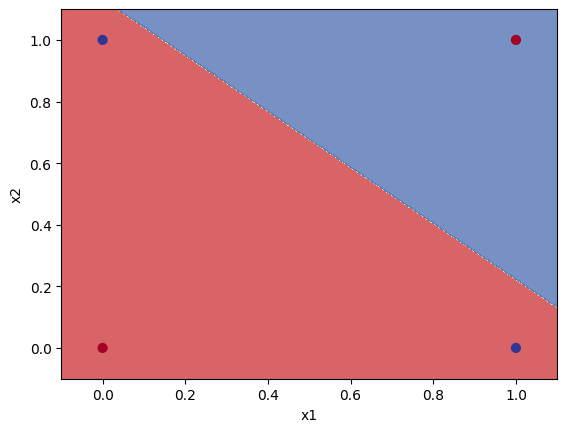

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7711/10000
1/1 ━━━━━━━━━━━━━━━━

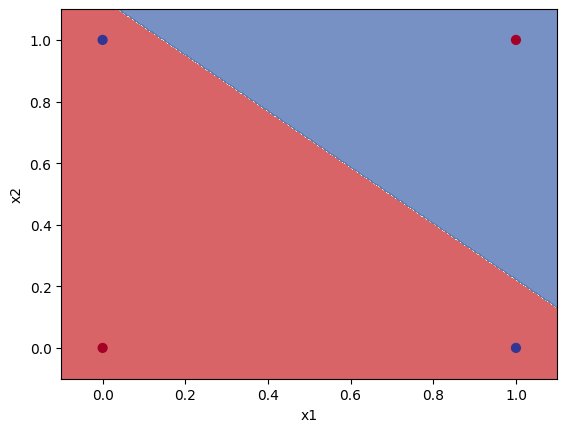

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7811/10000
1/1 ━━━━━━━━━━━━━━━━

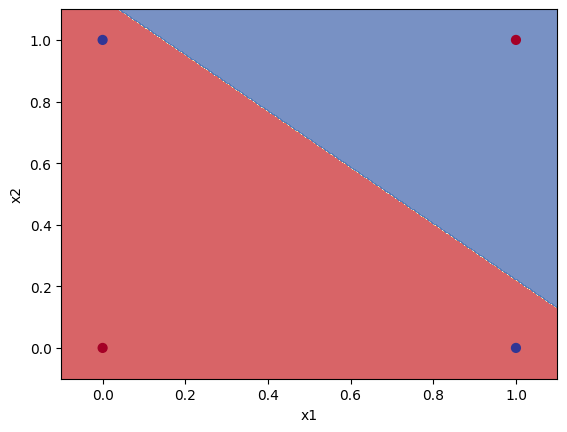

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 7911/10000
1/1 ━━━━━━━━━━━━━━━━

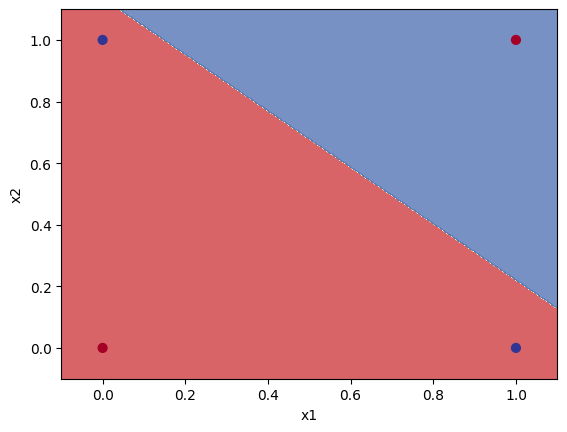

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8011/10000
1/1 ━━━━━━━━━━━━━━━━

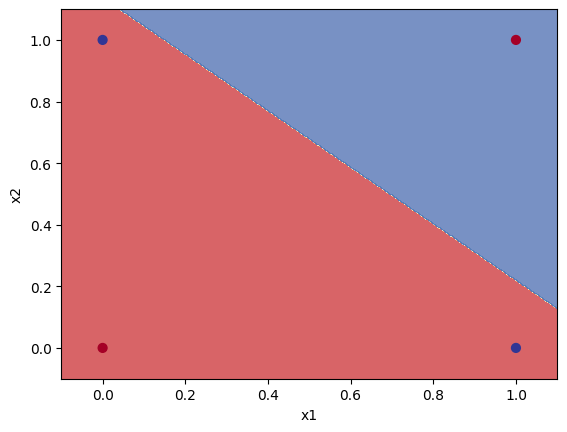

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8111/10000
1/1 ━━━━━━━━━━━━━━━━

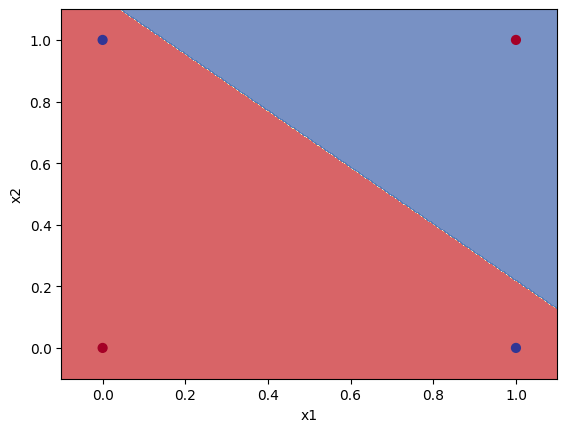

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8211/10000
1/1 ━━━━━━━━━━━━━━━━

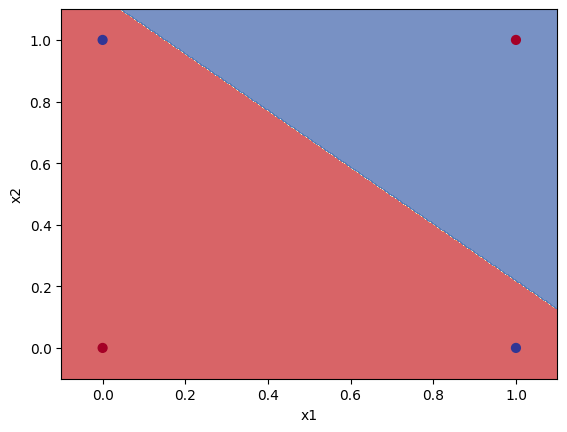

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8311/10000
1/1 ━━━━━━━━━━━━━━━━

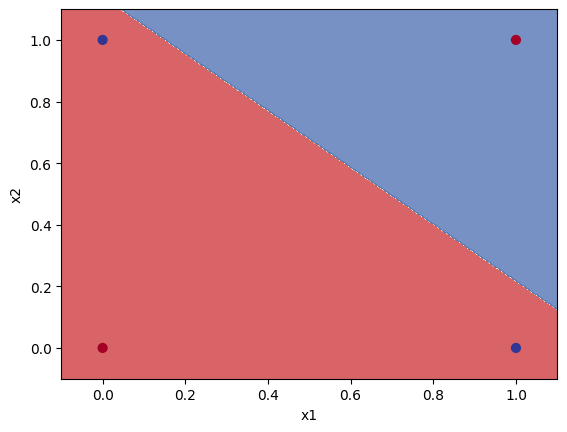

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8411/10000
1/1 ━━━━━━━━━━━━━━━━

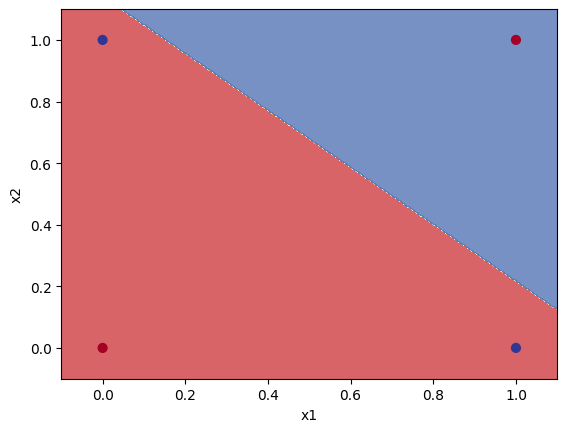

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8511/10000
1/1 ━━━━━━━━━━━━━━━━

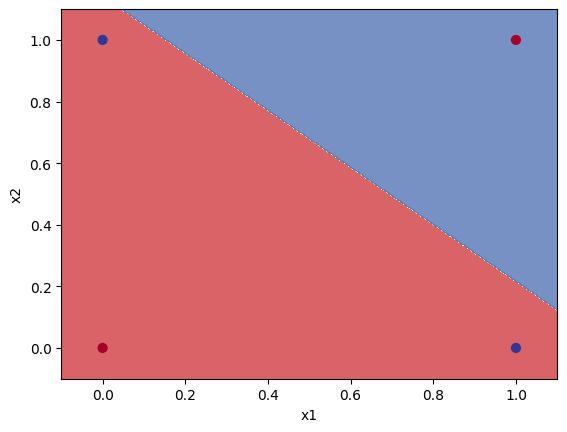

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8611/10000
1/1 ━━━━━━━━━━━━━━━━

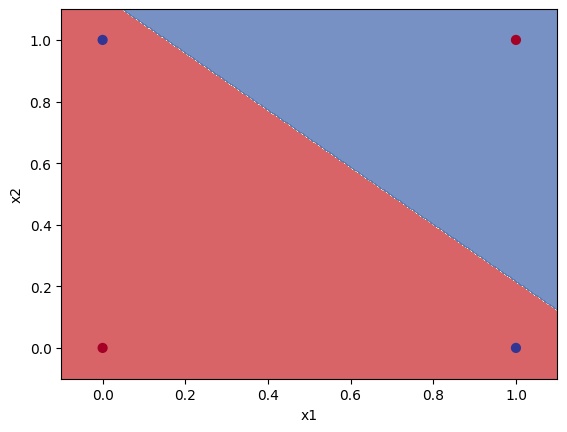

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8711/10000
1/1 ━━━━━━━━━━━━━━━━

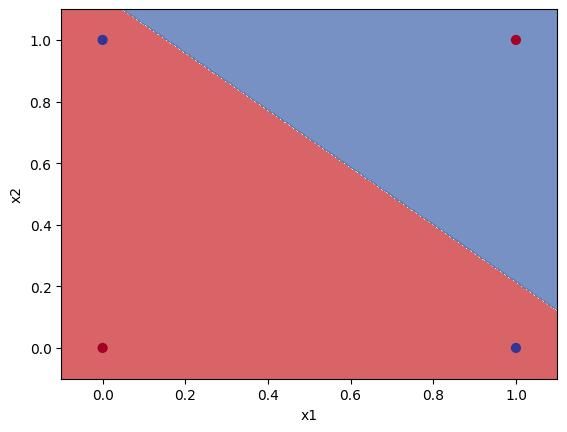

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8811/10000
1/1 ━━━━━━━━━━━━━━━━

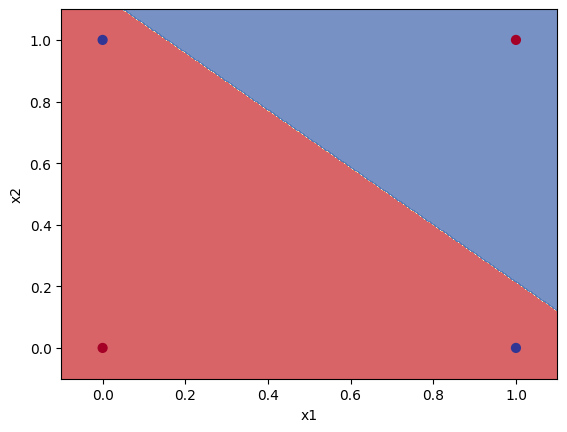

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 8911/10000
1/1 ━━━━━━━━━━━━━━━━

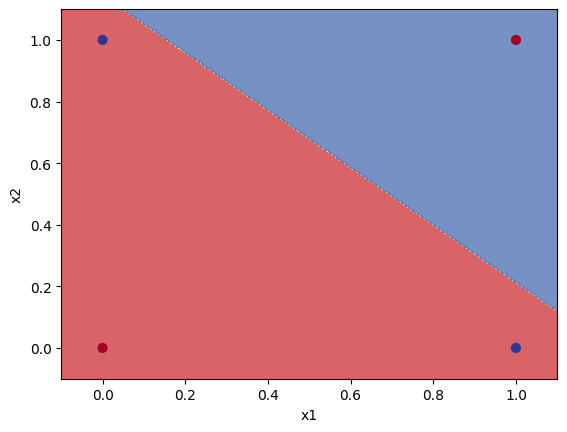

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9011/10000
1/1 ━━━━━━━━━━━━━━━━

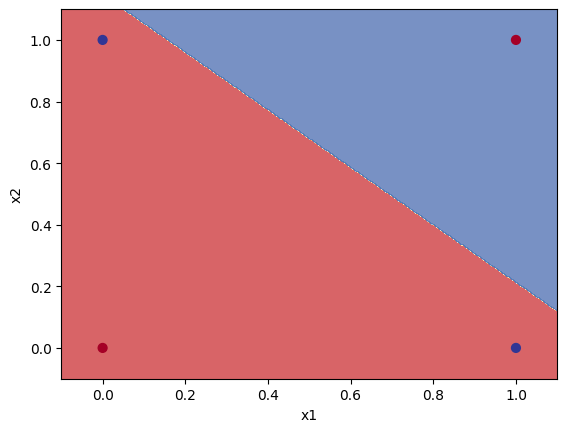

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9111/10000
1/1 ━━━━━━━━━━━━━━━━

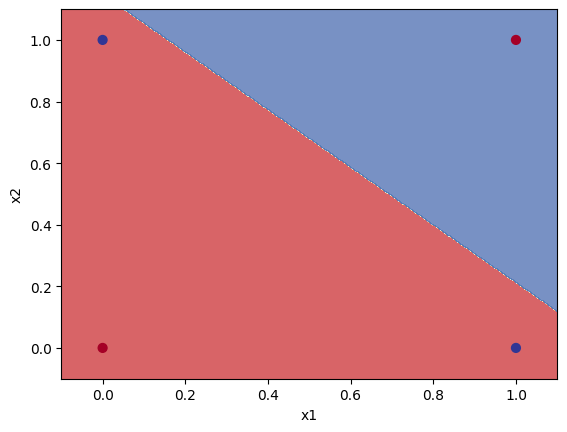

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9211/10000
1/1 ━━━━━━━━━━━━━━━━

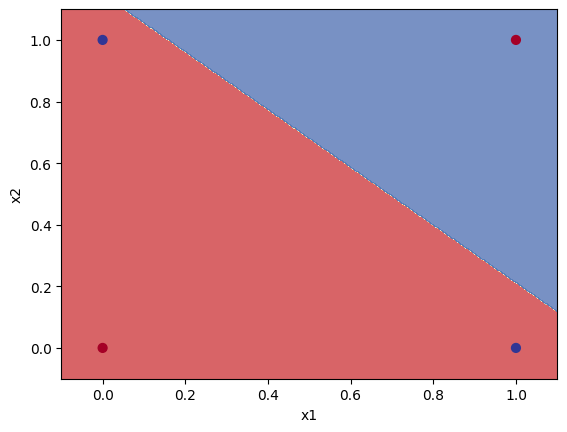

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9311/10000
1/1 ━━━━━━━━━━━━━━━━

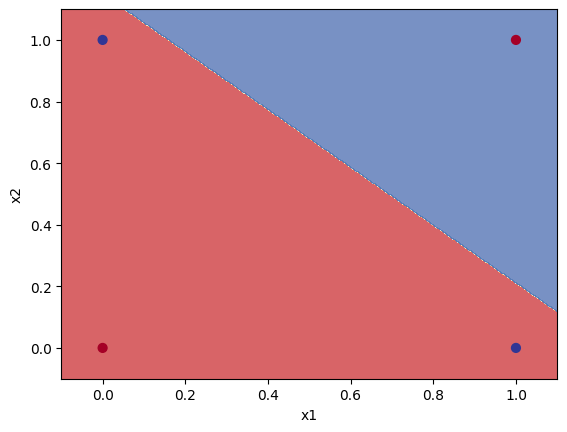

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9411/10000
1/1 ━━━━━━━━━━━━━━━━

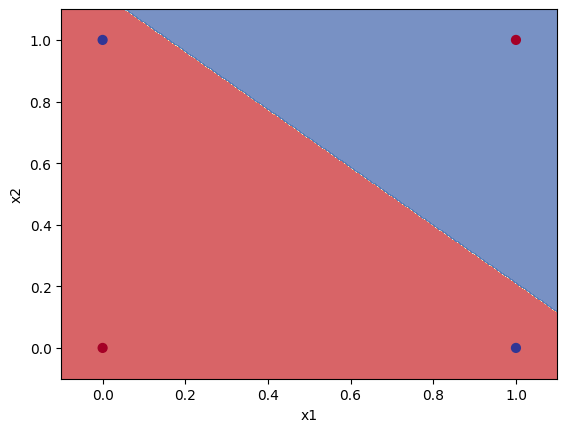

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9511/10000
1/1 ━━━━━━━━━━━━━━━━

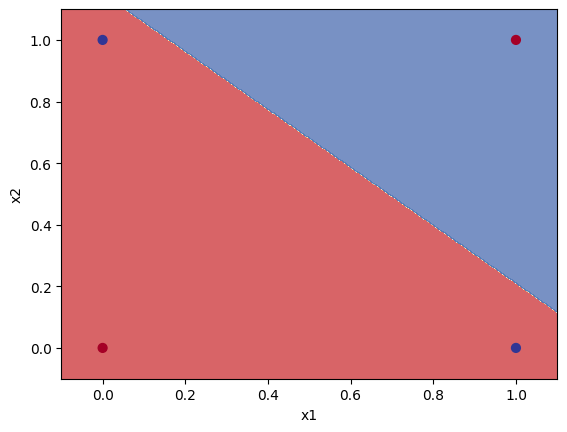

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9611/10000
1/1 ━━━━━━━━━━━━━━━━

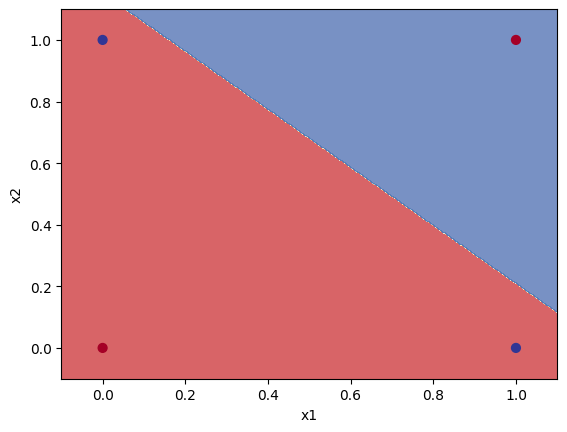

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9711/10000
1/1 ━━━━━━━━━━━━━━━━

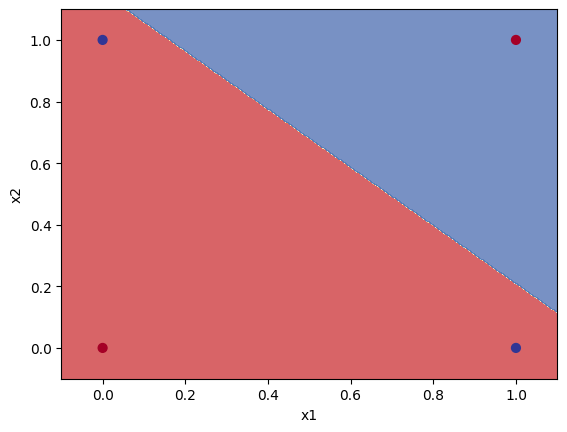

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9811/10000
1/1 ━━━━━━━━━━━━━━━━

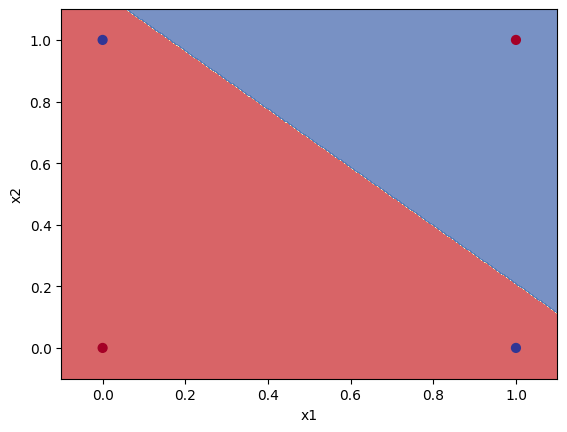

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.6932
Epoch 9911/10000
1/1 ━━━━━━━━━━━━━━━━

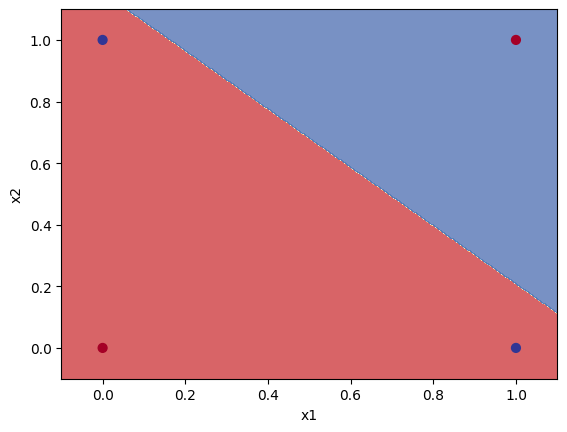

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.2500 - loss: 0.6932


In [5]:
model = trainModel(X, Y) # вызов обучения модели

In [6]:
input_data = np.array([[0, 1]])
testModel(input_data, model) # вызов тестирования обученной модели на тестовых данных

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.49959397]]


0

In [7]:
# Получить веса нейрона
model.get_weights()

[array([[0.00996079],
        [0.01052592]], dtype=float32),
 array([-0.01215008], dtype=float32)]